In [1]:
import os, sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import deque

import torch
from torch.distributions import Categorical

import gym

import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append('/Users/kanoumotoharu/Desktop/machine_learning/強化学習/reinforcement_learning/RL_algorithms/A2C_noise//')
from agent import  Agent
sys.path.append('/Users/kanoumotoharu/Desktop/machine_learning/強化学習/reinforcement_learning/RL_algorithms/Memory/')
from PrioritizedExperienceMemoryNsplit_add_value import ProportionalReplayNsplitMemory, RankReplayNsplitMemory

In [3]:
class Environment:
    def get_state(self, env, _obs):
        env_low = env.observation_space.low 
        env_high = env.observation_space.high 
        # normalize
        state = (_obs - env_low)/(env_high - env_low)
        return state.tolist()

    def get_reward(self, env, obs, next_obs, reward, action):
        low = env.observation_space.low[0]
        high = env.observation_space.high[0]
        reward = float((next_obs[0]-low)/(high-low))
        return reward
    
    def get_value(self, env, obs, next_obs, reward, action):
        low = env.observation_space.low[0]
        high = env.observation_space.high[0]
        
        value = float((next_obs[0]-low)/(high-low))
        value/=2
        if value<0.7:
            value = 0
        if value>0.9:
            value *= 2
        return value
    
    def get_action(self,env, action):
        action = int(action)
        return action

    def get_data(self, env, obs, next_obs, reward, action):
        state = self.get_state(env, obs)
        action = self.get_action(env, action)
        next_state = self.get_state(env, next_obs)
        reward = self.get_reward(env, obs, next_obs, reward, action)
        value = self.get_value(env, obs, next_obs, reward, action)

        return state, action, next_state, reward, value

In [4]:
from collections import deque

    
class Environment2:
    #stateの入力を増やしてみる
    def __init__(self, n=5):
        self.states_list = deque(maxlen=n)
        self.n = n
        
    def get_state(self, env, _obs):
        env_low = env.observation_space.low 
        env_high = env.observation_space.high 
        # normalize
        state = ((_obs - env_low)/(env_high - env_low)).tolist()
        if len(self.states_list)==0:
            for i in range(n):
                self.states_list.appendleft(state)
        return np.array(self.states_list).flatten().tolist()
    
    def get_nextstate(self, env, _obs):
        env_low = env.observation_space.low 
        env_high = env.observation_space.high 
        # normalize
        state = ((_obs - env_low)/(env_high - env_low)).tolist()
        self.states_list.appendleft(state)
        return np.array(self.states_list).flatten().tolist()

    def get_reward(self, env, obs, next_obs, reward, action):
        low = env.observation_space.low[0]
        high = env.observation_space.high[0]
        reward = float((next_obs[0]-low)/(high-low))
        reward = 1.3*reward - 0.3
        return reward
    
    def get_value(self, env, obs, next_obs, reward, action):
        low = env.observation_space.low[0]
        high = env.observation_space.high[0]
        value = float((next_obs[0]-low)/(high-low))
        if value<0.75:
            value = 0
        if value>=0.75:
            value = value
        if reward>=0:
            value = reward
        return value
    
    def get_action(self,env, action):
        action = int(action)
        return action

    def get_data(self, env, obs, next_obs, reward, action):
        state = self.get_state(env, obs)
        action = self.get_action(env, action)
        next_state = self.get_nextstate(env, next_obs)
        reward = self.get_reward(env, obs, next_obs, reward, action)
        value = self.get_value(env, obs, next_obs, reward, action)

        return state, action, next_state, reward, value

In [5]:
#make env
env = gym.make('MountainCar-v0')

In [6]:
action_space = env.action_space.n

#replay_memory = Replay_Memory(100000)
replay_memory = ProportionalReplayNsplitMemory(500,n=60)
#replay_memory = RankReplayNsplitMemory(2000,n=60, alpha=0)
n = 20
environment = Environment2(n)
agent = Agent(action_space=action_space, nSplit=True, sam=True, input_size=2*n, hidden_layers=[64,64])

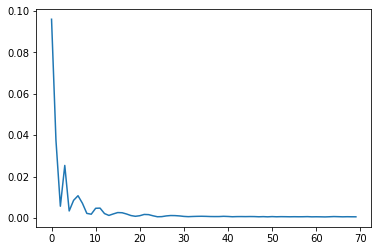

In [7]:
# 楽観的初期化
loss_list = agent.init_param_optim(70, env, environment)
plt.plot(loss_list)

In [8]:
actions = []
rewards = []
values = []
loss = []

In [9]:
# 10000エピソードで学習する
for episode in tqdm(range(5)):
    
    total_reward = 0
    total_value = 0
    observation = env.reset()
    environment = Environment2(n)
    replay_memory.ResetTemporalMemory()
    
    for _ in range(10000):
        env.render()
        
        # ε-グリーディ法で行動を選択        
        # get_stateにすれば状態が遅れないでOK
        now_state = environment.get_state(env, observation)
        now_state = torch.FloatTensor([now_state])
        action =  agent.get_action(now_state)
        actions.append(action)
        
        #環境を取得
        next_observation, reward, done, _ = env.step(action)
        
        # observe environment data
        state, action, next_state, reward, value = environment.get_data(env, observation, next_observation, reward, action)
        replay_memory.push(state, action, next_state, reward, value)

        #optim parameters
        _loss = agent.update_agent(replay_memory)
        total_reward += reward
        total_value += value
        
        if _loss is not None:
            loss.append(_loss)
        observation = next_observation
        
        if observation[0]>=env.observation_space.high[0]-0.001:
            # doneがTrueになったら１エピソード終了
            if episode%100 == 0:
                if episode==0:
                    mean_total_reward = total_reward
                else:
                    m = episode//100
                    mean_total_reward = np.mean(rewards[(m-1)*100:m*100])
                print(f'episode: {episode}, total_reward　mean: {mean_total_reward}')
            break
    rewards.append(total_reward)
    values.append(total_value)

episode: 0, total_reward　mean: 762.4121012059609



In [12]:
env.close()

In [13]:
agent.noise.current_stddev

0.11921161154572088

In [14]:
loss_df = pd.DataFrame(loss, columns=['loss'])
reward_df = pd.DataFrame(rewards, columns=['reward'])
value_df = pd.DataFrame(values, columns=['value'])
action_df = pd.DataFrame(actions, columns=['action'])

loss_df['loss_r30'] = loss_df['loss'].rolling(30,min_periods=1).mean()
reward_df['reward_r30'] = reward_df['reward'].rolling(30,min_periods=1).mean()
value_df['value_r30'] = value_df['value'].rolling(30,min_periods=1).mean()
action_df['action'] = action_df['action'].map({0:"push left", 1:"no push", 2:"push right"})

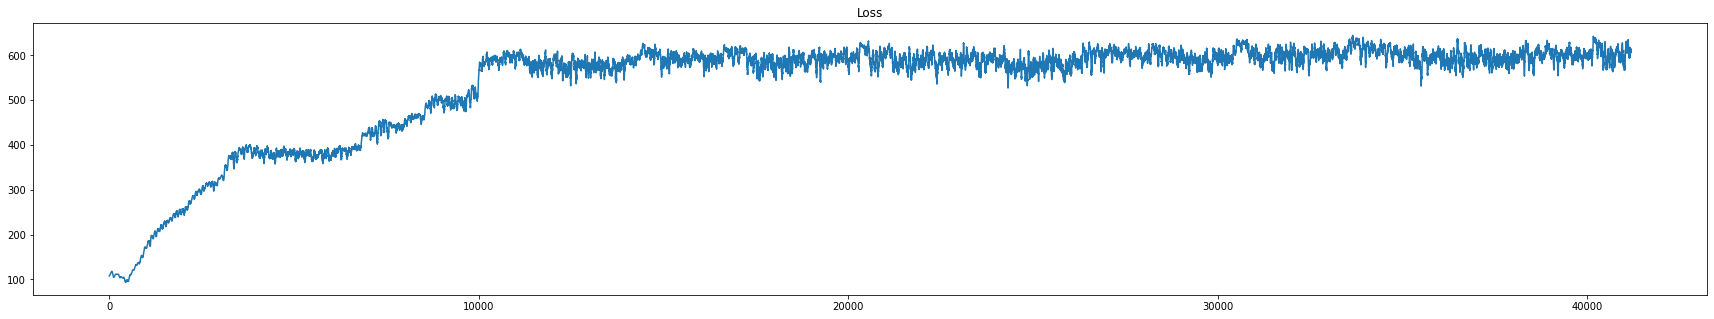

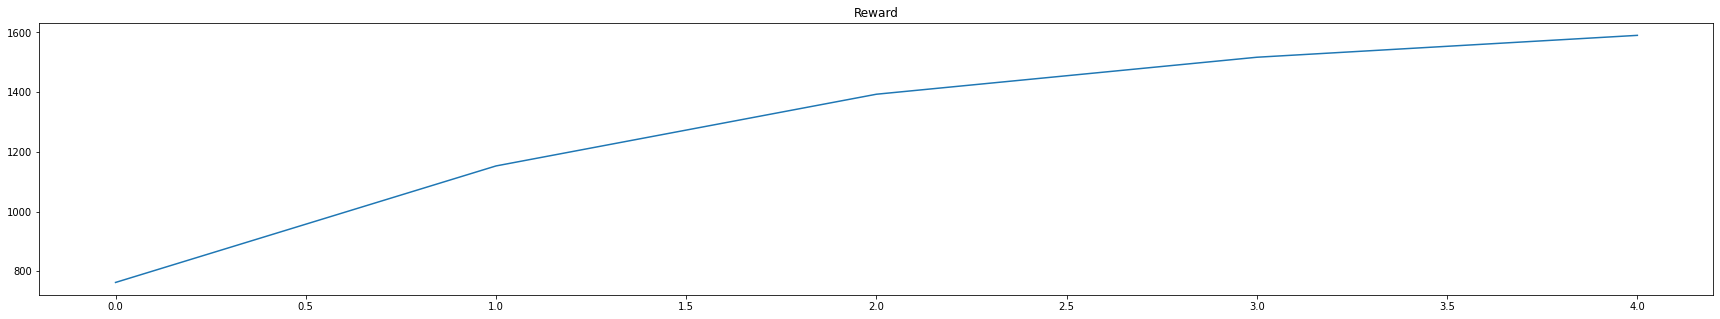

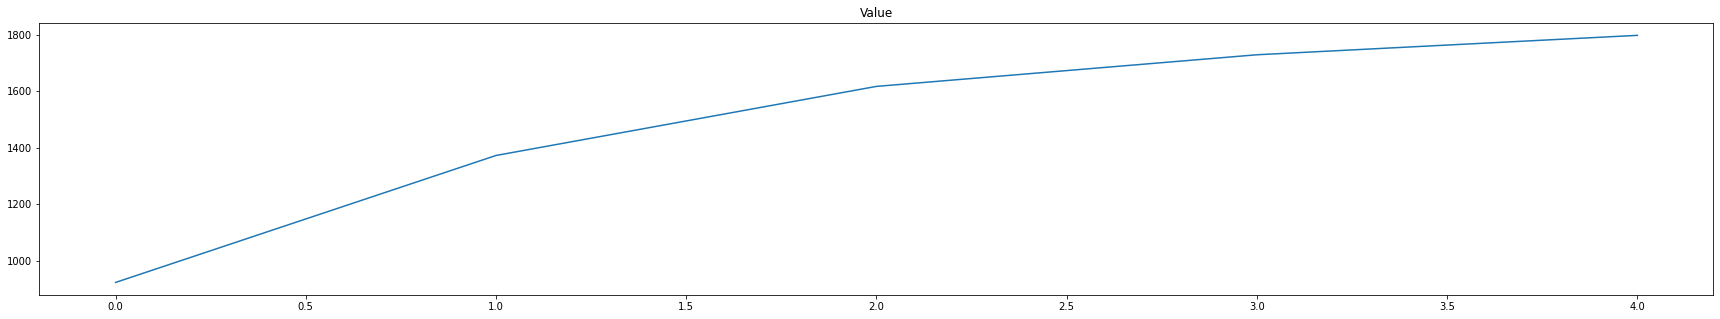

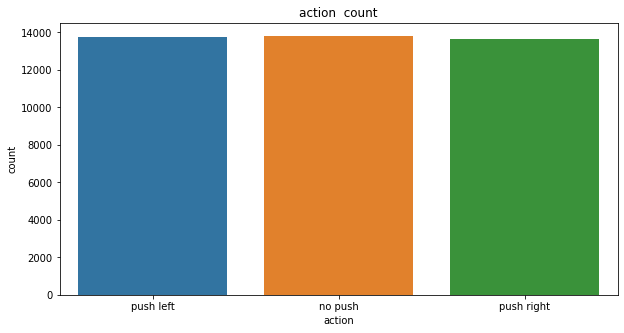

In [15]:
plt.figure(figsize=(30,5))
plt.plot(loss_df['loss_r30'])
plt.title('Loss')
plt.show()

plt.figure(figsize=(30,5))
plt.plot(reward_df['reward_r30'])
plt.title('Reward')
plt.show()

plt.figure(figsize=(30,5))
plt.plot(value_df['value_r30'])
plt.title('Value')
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(action_df["action"], order=["push left", "no push","push right"])
plt.title("action  count")
plt.show()

In [16]:
observation = env.reset()
environment = Environment2(n)
now_state = environment.get_state(env, observation)
for _ in range(10000):
        env.render()
        # ε-グリーディ法で行動を選択        
        now_state = environment.get_nextstate(env, observation)
        now_state = torch.FloatTensor([now_state])
        action =  agent.get_action(now_state)
        next_observation, reward, done, _ = env.step(action)
        observation = next_observation
        
        if observation[0]>=env.observation_space.high[0]-0.001:
            rewards.append(total_reward)
            # doneがTrueになったら１エピソード終了
            if episode%100 == 0:
                if episode==0:
                    mean_total_reward = total_reward
                else:
                    m = episode//100
                    mean_total_reward = np.mean(rewards[(m-1)*100:m*100])
                print(f'episode: {episode}, total_reward　mean: {mean_total_reward}')
            break

In [17]:
env.close()

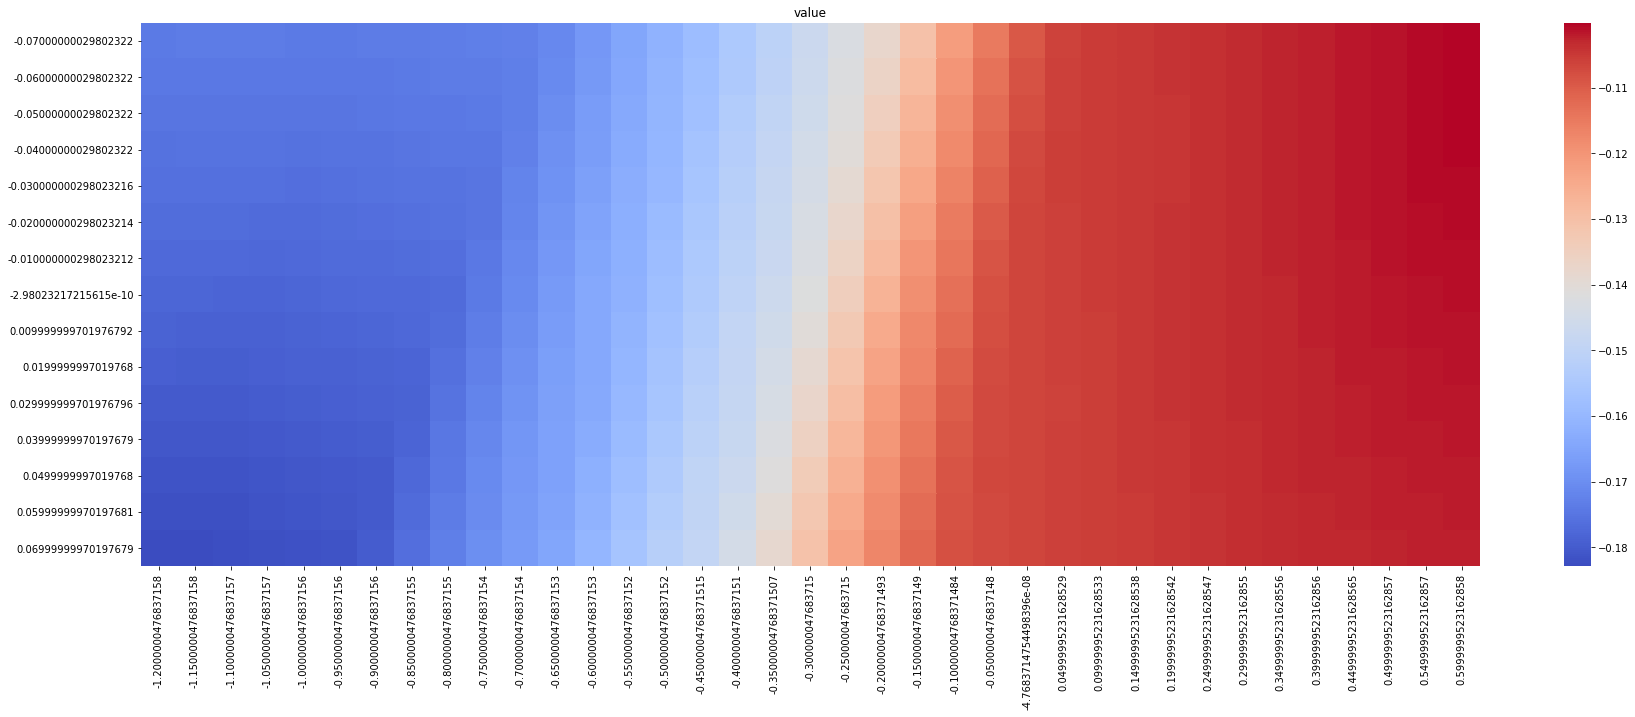

In [18]:
low_0 = env.observation_space.low[0]
high_0 = env.observation_space.high[0]
low_1 = env.observation_space.low[1]
high_1 = env.observation_space.high[1]

df = []
for x_0 in np.arange(low_0, high_0,0.05):
    x=[]
    tmp_df = pd.DataFrame(index=np.arange(low_1, high_1,0.01))
    for x_1 in np.arange(low_1, high_1,0.01):
        y = []
        for _ in range(n):
            y+=[x_0, x_1]
        x.append(y)

    x = torch.FloatTensor(x)
    y = agent.model(x)['value'].detach().numpy().flatten()
    tmp_df[x_0] = y
    df.append(tmp_df)

df = pd.concat(df, axis=1)
plt.figure(figsize=(30,10))
sns.heatmap(df, cmap='coolwarm')
plt.title('value')
plt.show()

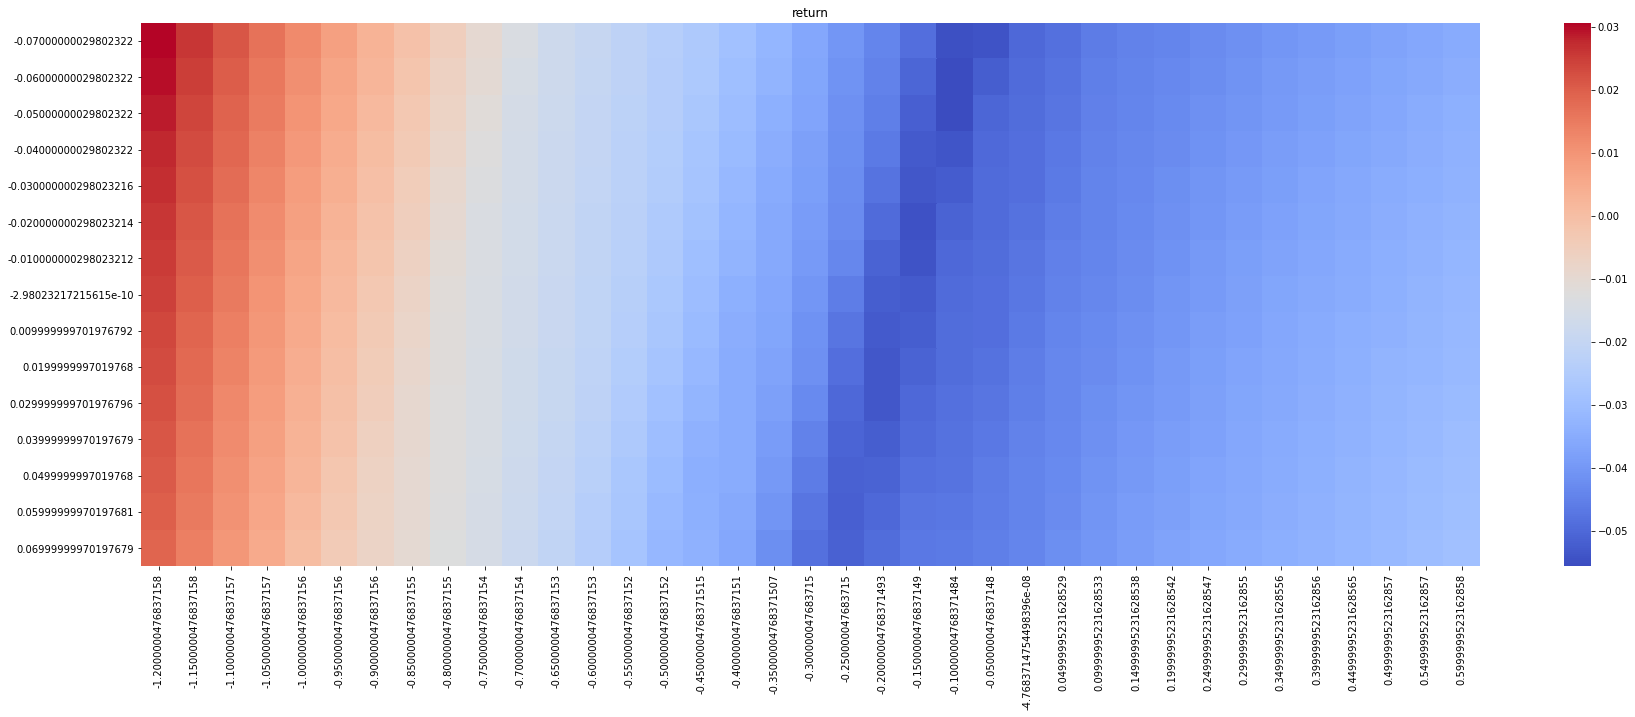

In [19]:
low_0 = env.observation_space.low[0]
high_0 = env.observation_space.high[0]
low_1 = env.observation_space.low[1]
high_1 = env.observation_space.high[1]

df = []
for x_0 in np.arange(low_0, high_0,0.05):
    x=[]
    tmp_df = pd.DataFrame(index=np.arange(low_1, high_1,0.01))
    for x_1 in np.arange(low_1, high_1,0.01):
        y = []
        for _ in range(n):
            y+=[x_0, x_1]
        x.append(y)

    x = torch.FloatTensor(x)
    y = agent.model(x)['return'].detach().numpy().flatten()
    tmp_df[x_0] = y
    df.append(tmp_df)

df = pd.concat(df, axis=1)
plt.figure(figsize=(30,10))
sns.heatmap(df, cmap='coolwarm')
plt.title('return')
plt.show()

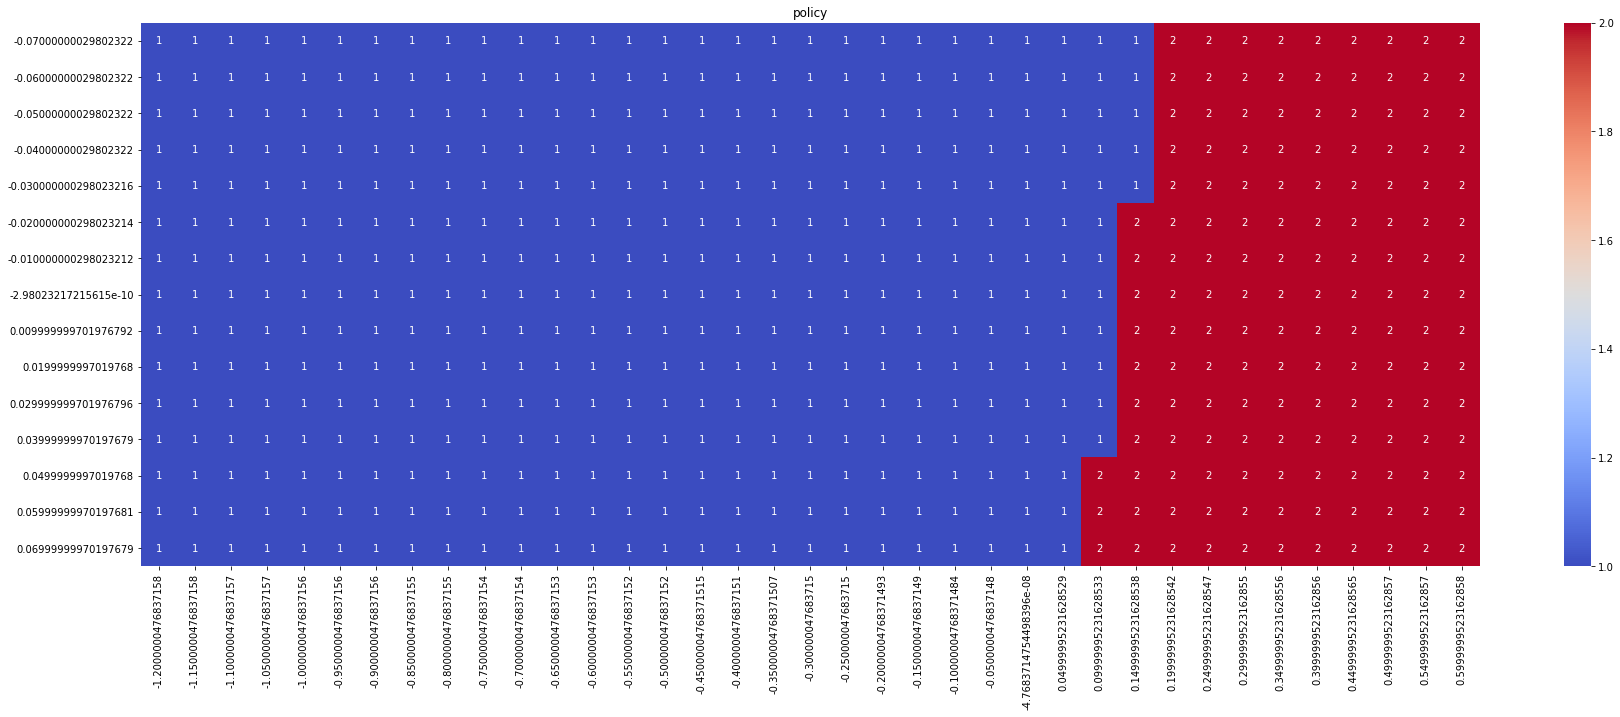

In [20]:
low_0 = env.observation_space.low[0]
high_0 = env.observation_space.high[0]
low_1 = env.observation_space.low[1]
high_1 = env.observation_space.high[1]

df = []
for x_0 in np.arange(low_0, high_0,0.05):
    x=[]
    tmp_df = pd.DataFrame(index=np.arange(low_1, high_1,0.01))
    for x_1 in np.arange(low_1, high_1,0.01):
        y = []
        for _ in range(n):
            y+=[x_0, x_1]
        x.append(y)

    x = torch.FloatTensor(x)
    y = agent.model(x)['policy'].detach().numpy()
    tmp_df[x_0] = y.argmax(1)
    df.append(tmp_df)

df = pd.concat(df, axis=1)
plt.figure(figsize=(30,10))
sns.heatmap(df, cmap='coolwarm', annot=True)
plt.title('policy')
plt.show()

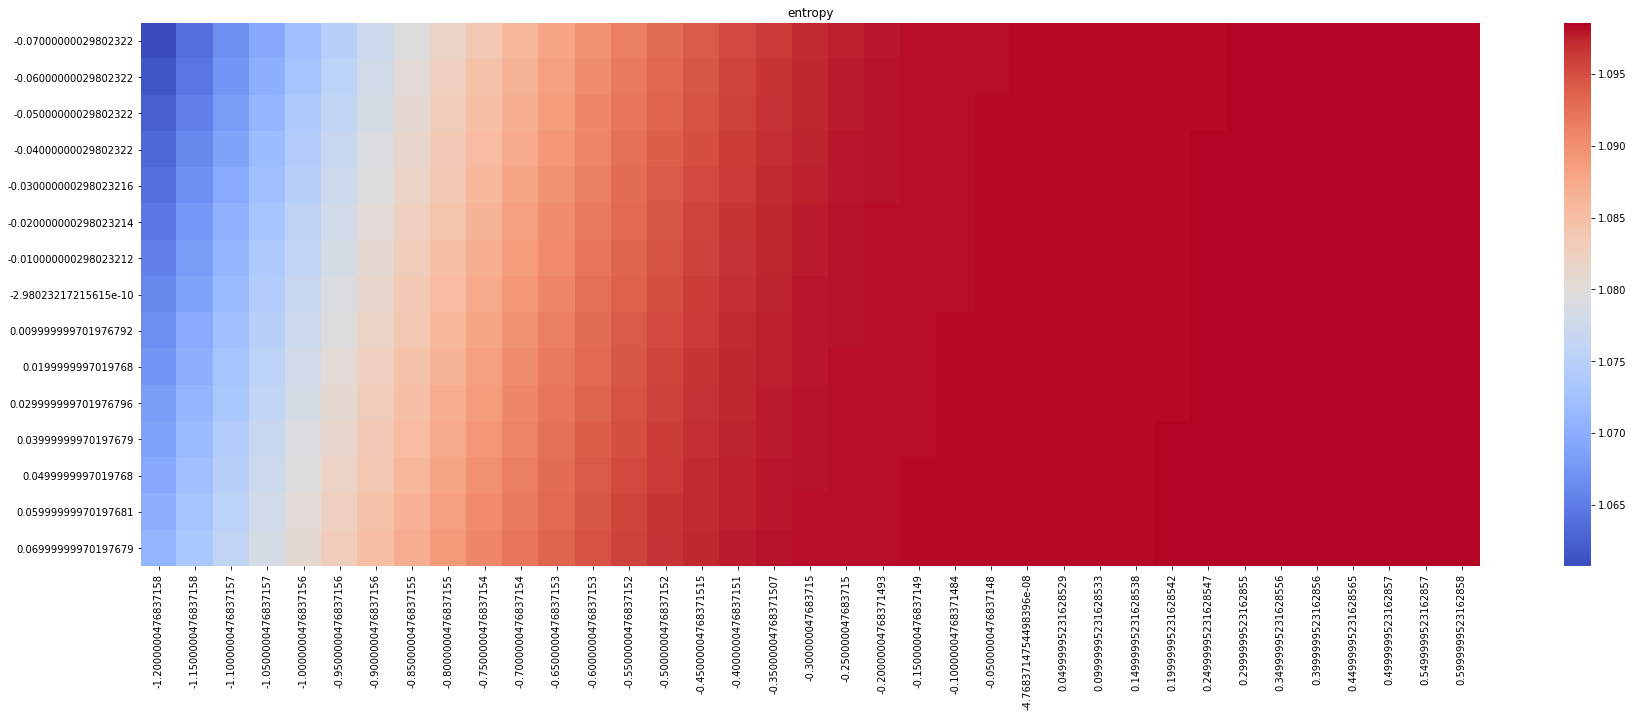

In [21]:
low_0 = env.observation_space.low[0]
high_0 = env.observation_space.high[0]
low_1 = env.observation_space.low[1]
high_1 = env.observation_space.high[1]

df = []
for x_0 in np.arange(low_0, high_0,0.05):
    x=[]
    tmp_df = pd.DataFrame(index=np.arange(low_1, high_1,0.01))
    for x_1 in np.arange(low_1, high_1,0.01):
        y = []
        for _ in range(n):
            y+=[x_0, x_1]
        x.append(y)

    x = torch.FloatTensor(x)
    y = agent.model(x)['policy'].detach()
    y = Categorical(logits=y).entropy()
    tmp_df[x_0] = y
    df.append(tmp_df)

df = pd.concat(df, axis=1)
plt.figure(figsize=(30,10))
sns.heatmap(df, cmap='coolwarm')
plt.title('entropy')
plt.show()